# Raspagem de documentos via Web
### Obtenção dos dados textuais dos documentos da Rede Social do Café

## Bibliotecas utilizadas

In [2]:
import urllib3
import ssl
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from urllib3 import Timeout

import bs4
from bs4 import BeautifulSoup

import csv
import logging
import json
import unicodedata
import os
import re

import numpy as np
import matplotlib.pyplot as plt

## Obtém o texto de cada documento  do fórum pelo seu ID, via biblioteca Beautiful Soup
Obs: acesso não autenticado, documentos de comentários não foram coletados

In [8]:
def get_documento_texto_por_id(id):
    try:
        headers = {
        'Upgrade-Insecure-Requests': '1',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_2) AppleWebKit/537.36 (KHTML, like Gecko) '
                      'Chrome/72.0.3626.119 Safari/537.36',
        'DNT': '1'
        }
        # Obtem texto de um documento específico
        url = 'http://www.redepeabirus.com.br/redes/form/post?topico_id=' + str(id)
        print(url)
        response = session.get(url , headers=headers, verify=False)
        soup = bs4.BeautifulSoup(response.text, "html.parser")
        # Identifica escopo do documento (1a ocorencia, comentários adicionais não foram considerados)
        elements = soup.find("div", {'class':'defPost'})
        if "Não foi possível obter a página" in elements.text:
            # se mensagem de insucesso
            return False
        else:
            content = elements.text
            #print(content)
            return content
    except Exception as err:
       print(err) 


## Obtém o conjunto de documentos específicados por uma lista de Ids

In [9]:
#Obtém o conjunto de documentos específicados
def raspa_documentos_lista(lista_documentos):

    for documento_id in lista_documentos:

        documento_id_str = str(documento_id)
        documento = get_documento_texto_por_id(documento_id)

        if documento:
            documento_lines = documento.splitlines()

            # Obtém a primeira linha após linhas em branco para extração da data e hora de publicação
            
            for line in documento_lines:
                if not line.strip():
                        continue
                else:
                        primeira_linha = line
                        break
            # Faz o parsing da data e hora para compor o nome do arquivo
            match = re.match(r'''
    .+
    (
    (\d{2})\/(\d{2})\/(\d{4})
    \s+?
    (\d{2})\:(\d{2})
    )
    .*  
    ''', primeira_linha, re.VERBOSE)
            filepath = '../data/raspagem/' + 'rsc_scraping_' + match[4] + '_' + match[3] + '_' + match[2] + '_' + match[5] + 'h' + match[6] + '_id_' + documento_id_str + '.txt'
            f = open(filepath, "w", encoding='utf-8' )
            logokf = open('../log/scrapping_ok.log', "a+", encoding='utf-8' )
            logokf.write(documento_id_str + '\n')
            print ("Documento Id: " +  documento_id_str)
            print('Gravado em:' + filepath)
            f.write(documento)
            f.close()
            logokf.close()
        else:
            print ("Documento inexistente: " +  documento_id_str)
            logfailf = open('../log/scrapping_failure.log', "a+", encoding='utf-8' )
            logfailf.write(documento_id_str + '\n')
            logfailf.close()


## Início da execução

## Cria sessão para requisições http

In [3]:
# Como a velocidde de obtenção dos documentos era reativamente lenta,, e eventualmente ocorrima erros da aplicação devidos 
# ao tempo de # resposta, oram utilizadas algumas técnicas para contorno
# ver https://stackoverflow.com/questions/23267409/how-to-implement-retry-mechanism-into-python-requests-library
# e https://www.peterbe.com/plog/best-practice-with-retries-with-requests

MAX_RETRY = 2
MAX_RETRY_FOR_SESSION = 4
BACK_OFF_FACTOR = 0.5
ERROR_CODES = (500, 502, 504)

def requests_retry_session(retries=MAX_RETRY_FOR_SESSION,
    back_off_factor=BACK_OFF_FACTOR,
    status_force_list=ERROR_CODES, 
    session=None):
    session = session
    retry = Retry(total=retries, read=retries, connect=retries,
                 backoff_factor=back_off_factor,
                 status_forcelist=status_force_list,
                 method_whitelist=frozenset(['GET', 'POST']))
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session


# Cria sessão de requisições http

session = requests_retry_session(session=requests.Session())

## Processa um range dos documentos desejados

In [13]:
# Cria lista de documentoss cobertos pela paginação do fórum em amostragem de 06/03/2021

lista_id_documentos = range(89625,57630,-1)
raspa_documentos_lista(lista_id_documentos)

http://www.redepeabirus.com.br/redes/form/post?topico_id=89625
Documento Id: 89625
Gravado em:../data/scraping-3/rsc_scraping_2021_03_07_06h32_id_89625.txt
http://www.redepeabirus.com.br/redes/form/post?topico_id=89624
Documento Id: 89624
Gravado em:../data/scraping-3/rsc_scraping_2021_03_07_06h29_id_89624.txt
http://www.redepeabirus.com.br/redes/form/post?topico_id=89623
Documento Id: 89623
Gravado em:../data/scraping-3/rsc_scraping_2021_03_07_06h21_id_89623.txt
http://www.redepeabirus.com.br/redes/form/post?topico_id=89622
Documento Id: 89622
Gravado em:../data/scraping-3/rsc_scraping_2021_03_07_06h14_id_89622.txt
http://www.redepeabirus.com.br/redes/form/post?topico_id=89621
Documento Id: 89621
Gravado em:../data/scraping-3/rsc_scraping_2021_03_05_13h04_id_89621.txt
http://www.redepeabirus.com.br/redes/form/post?topico_id=89620
Documento Id: 89620
Gravado em:../data/scraping-3/rsc_scraping_2021_03_05_11h21_id_89620.txt
http://www.redepeabirus.com.br/redes/form/post?topico_id=89619
D

KeyboardInterrupt: 

## Histograma de distribuição de documentos por tamanho

In [64]:
# Cria um histograma formatado em caracteres
# ref.: https://gist.github.com/tammoippen
def crappyhist(a, bins=10, width=140):
    h, b = np.histogram(a, bins)

    for i in range (0, bins):
        print('{:12.0f}  | {:{width}s} {}'.format(
            b[i], 
            '#'*int(width*h[i]/np.amax(h)), 
            h[i], 
            width=width))
    print('{:12.0f}  |'.format(b[bins]))

In [ ]:
# Levantamento de tamanho dos arquivos resultantes

results = []
path = '../data/raspagem'
filenames = os.listdir(path)
for filename in [f for f in filenames if f.endswith('.txt')]: 
    fullpath = path + '/' + filename
    results.append(os.path.getsize(fullpath))
#converte resultado para um numpy array
np_results = np.array(results)

In [67]:
##### Mostra histograma em formato caracter
crappyhist(np_results, bins=50, width=80)

         127  | ################################################################################ 27284
        1756  | ####################################################                             17798
        3384  | #########################                                                        8607
        5013  | #########                                                                        3346
        6642  | ###                                                                              1255
        8270  | #                                                                                647
        9899  |                                                                                  255
       11528  |                                                                                  183
       13157  |                                                                                  97
       14785  |                                                                      

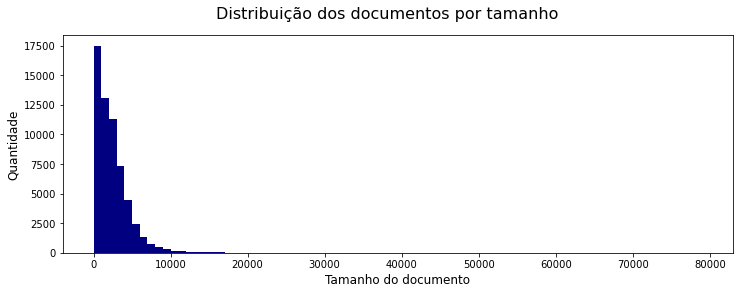

In [63]:
# Geração do histograma

plt.figure(figsize=(12,4))
plt.hist(np_results, bins = np.arange(0,80000,1000), color='navy')
plt.suptitle('Distribuição dos documentos por tamanho', fontsize=16)
plt.xlabel('Tamanho do documento', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
#plt.xlim(xmin=0, xmax = 10000)
plt.show()